# Import Important Packages

In [1]:
import tensorflow as tf
import numpy as np
from glob import glob
import os, random

print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.10.0


# Check GPU Available

In [2]:
print("GPU Available: ", tf.config.list_physical_devices("GPU"))
!nvidia-smi -L

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU 0: NVIDIA GeForce RTX 3050 Laptop GPU (UUID: GPU-509cf0ce-8a5d-aa4a-fa20-6093938c3e7e)


# Exploratory Data Analyst

Dataset ini diekspor melalui [universe.roboflow.com](https://universe.roboflow.com/palm-fruit-classification/palm-fruit-ripeness-classificationcnn) pada 23 September 2023 pukul 04.36 GMT

Kumpulan data mencakup 3024 gambar.
Buah sawit dalam format klip.

Pra-pemrosesan berikut diterapkan pada setiap gambar:
* Orientasi otomatis data piksel (dengan stripping orientasi EXIF)
* Ubah ukuran menjadi 299x299 (Peregangan)

In [3]:
train_path = "G:/My Drive/Dataset/Corn Leaf Disease"
images_path = glob(train_path + "/*/*.jp*g")
classname = os.listdir(train_path)

## View Image Randomly

Image Shape:  (256, 256, 3)
G:/My Drive/Dataset/Corn Leaf Disease\Hawar Daun Jagung\CornNorthernLeafBlight(1005).JPG


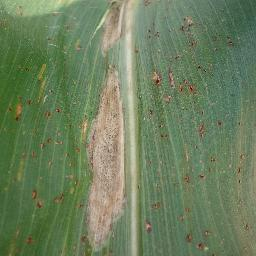

In [4]:
from IPython.display import Image
import matplotlib.image as mpimg

random_index_img = random.randint(0, 3024)
print("Image Shape: ", mpimg.imread(images_path[random_index_img]).shape)
print(images_path[random_index_img])
Image(images_path[random_index_img])

# Get Dataset From Directory

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1/255.,
                            validation_split=0.2)

train_data = datagen.flow_from_directory(train_path,
                                        target_size = (224, 224),
                                        subset = "training",
                                        shuffle = True,
                                        class_mode = 'categorical')

val_data = datagen.flow_from_directory(train_path,
                                      target_size = (224, 224),
                                      subset = 'validation',
                                      shuffle = True,
                                      class_mode = 'categorical')

Found 10705 images belonging to 4 classes.
Found 2675 images belonging to 4 classes.


In [6]:
from tensorflow.keras.utils import image_dataset_from_directory

train_data = image_dataset_from_directory(train_path,
                                          image_size=(224, 224),
                                          validation_split=0.2,
                                          subset = "training",
                                          label_mode = "categorical",
                                          seed = 42,
                                          shuffle=True)
val_data = image_dataset_from_directory(train_path,
                                        image_size=(224, 224),
                                        validation_split=0.2,
                                        subset="validation",
                                        label_mode = "categorical",
                                        seed = 42,
                                        shuffle=True)

Found 13380 files belonging to 4 classes.
Using 10704 files for training.
Found 13380 files belonging to 4 classes.
Using 2676 files for validation.


In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
import datetime

logdir = "../Logs/corn/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

early_stopping = EarlyStopping(monitor = "val_accuracy",
                               patience = 10,
                               restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                              mode = 'max',
                              factor = 0.2,
                              patience = 2,
                              min_lr=1e-5)

tensorboard = TensorBoard(logdir)

# Creating a MobileNet Architecture Model

In [12]:
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras import Model
checkpoint_path = "../Checkpoint/corn/corn-mobilenetv3small-" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + ".ckpt"

base_model = MobileNetV3Small(minimalistic = True,
                              include_top = False,
                              weights = 'imagenet')
mobilenet_preprocessor = preprocess_input
for layer in base_model.layers:
  layer.trainable = True

input = Input(shape = (224, 224, 3))
prep_input = mobilenet_preprocessor(input)
x = base_model(prep_input)
x = Flatten()(x)
output = Dense(4, activation = "softmax")(x)

model = Model(inputs = input, outputs=output)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, None, None, 576)  441000    
 l)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 28224)             0         
                                                                 
 dense_1 (Dense)             (None, 4)                 112900    
                                                                 
Total params: 553,900
Trainable params: 541,788
Non-trainable params: 12,112
_________________________________________________________________


# Compile the Model

In [13]:
model.compile(loss ="categorical_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

In [14]:
history = model.fit(train_data,
                    validation_data = val_data,
                    epochs = 100,
                    steps_per_epoch = len(train_data),
                    validation_steps = len(val_data),
                    callbacks = [early_stopping, reduce_lr, tensorboard])

model.save_weights(checkpoint_path)

Epoch 1/100
335/335 [==============================] - 58s 164ms/step - loss: 0.2413 - accuracy: 0.9403 - val_loss: 5.3826 - val_accuracy: 0.7179 - lr: 0.0010
Epoch 2/100
335/335 [==============================] - 54s 156ms/step - loss: 0.0414 - accuracy: 0.9872 - val_loss: 0.9278 - val_accuracy: 0.8976 - lr: 0.0010
Epoch 3/100
335/335 [==============================] - 56s 161ms/step - loss: 0.0641 - accuracy: 0.9816 - val_loss: 15.9654 - val_accuracy: 0.6487 - lr: 0.0010
Epoch 4/100
335/335 [==============================] - 58s 169ms/step - loss: 0.0907 - accuracy: 0.9748 - val_loss: 8.1918 - val_accuracy: 0.6801 - lr: 0.0010
Epoch 5/100
335/335 [==============================] - 56s 162ms/step - loss: 0.0232 - accuracy: 0.9922 - val_loss: 0.5985 - val_accuracy: 0.9283 - lr: 2.0000e-04
Epoch 6/100
335/335 [==============================] - 58s 169ms/step - loss: 0.0063 - accuracy: 0.9983 - val_loss: 0.1781 - val_accuracy: 0.9652 - lr: 2.0000e-04
Epoch 7/100
335/335 [================

In [15]:
model.evaluate(val_data)

84/84 [==============================] - 12s 127ms/step - loss: 0.0727 - accuracy: 0.9832


[0.07271953672170639, 0.9831838607788086]

# Load Checkpoint

In [ ]:
model.load_weights("C:\Users\salma\pyworkspace\Checkpoint\corn\corn-mobilenetv3small-20231017-021516.ckpt")
model.evaluate(val_data)

19/19 [==============================] - 6s 287ms/step - loss: 1.4099 - accuracy: 0.4236


[1.4098715782165527, 0.4235880374908447]

# Evaluate

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()
	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)
	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')
	else:
		print('Confusion Matrix, Without Normalization')
	print(cm)
	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
y_pred = np.array([])
y_val =  np.array([])
for x, y in val_data:
  y_pred = np.concatenate([y_pred, np.argmax(model.predict(x), axis = -1)])
  y_val = np.concatenate([y_val, np.argmax(y, axis=-1)])

1/1 [==============================] - 0s 25ms/step


ResourceExhaustedError: Graph execution error:

Detected at node 'model/MobilenetV3small/expanded_conv_1/depthwise/pad/Pad' defined at (most recent call last):
    File "c:\Users\salma\pyworkspace\.conda\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\salma\pyworkspace\.conda\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\salma\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\salma\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 1046, in launch_instance
      app.start()
    File "C:\Users\salma\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "C:\Users\salma\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\salma\pyworkspace\.conda\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\salma\pyworkspace\.conda\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\salma\pyworkspace\.conda\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\salma\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "C:\Users\salma\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "C:\Users\salma\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "C:\Users\salma\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "C:\Users\salma\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\salma\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\salma\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "C:\Users\salma\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "C:\Users\salma\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\salma\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\salma\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\salma\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\salma\AppData\Local\Temp\ipykernel_17424\3420389761.py", line 4, in <module>
      y_pred = np.concatenate([y_pred, np.argmax(model.predict(x), axis = -1)])
    File "c:\Users\salma\pyworkspace\.conda\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\salma\pyworkspace\.conda\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\salma\pyworkspace\.conda\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "c:\Users\salma\pyworkspace\.conda\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\salma\pyworkspace\.conda\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\salma\pyworkspace\.conda\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "c:\Users\salma\pyworkspace\.conda\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\salma\pyworkspace\.conda\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\salma\pyworkspace\.conda\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\salma\pyworkspace\.conda\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\salma\pyworkspace\.conda\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\salma\pyworkspace\.conda\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\salma\pyworkspace\.conda\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\salma\pyworkspace\.conda\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\salma\pyworkspace\.conda\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\salma\pyworkspace\.conda\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\salma\pyworkspace\.conda\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\salma\pyworkspace\.conda\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\salma\pyworkspace\.conda\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\salma\pyworkspace\.conda\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\salma\pyworkspace\.conda\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\salma\pyworkspace\.conda\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\salma\pyworkspace\.conda\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\salma\pyworkspace\.conda\lib\site-packages\keras\layers\reshaping\zero_padding2d.py", line 149, in call
      return backend.spatial_2d_padding(
    File "c:\Users\salma\pyworkspace\.conda\lib\site-packages\keras\backend.py", line 4031, in spatial_2d_padding
      return tf.compat.v1.pad(x, pattern)
Node: 'model/MobilenetV3small/expanded_conv_1/depthwise/pad/Pad'
OOM when allocating tensor with shape[32,57,57,72] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/MobilenetV3small/expanded_conv_1/depthwise/pad/Pad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_16991]

## Confusion Matrix

In [ ]:
cm = confusion_matrix(y_val, y_pred)
plot_confusion_matrix(cm = cm, classes = classname)

NameError: ignored

## Classification Report

In [ ]:
classification_report(y_val, y_pred)